In [1]:
# Зададим стили 
from IPython.display import HTML
with open('./styles/overall.css', 'r') as stl:
    style = stl.read()
HTML(style)

In [2]:
# Графические утилитки 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

In [3]:
# Библиотеки для работы с данными 
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from src.tests import (dickey_fuller_test, 
                       kpss_test
                      )
from src.utils import (extrapolate_trend, 
                       extrapolate_seasonal,
                       exponential_smoothing,
                       DecompositionType
                       )

In [4]:
# Магия для отключения предупреждений 
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
# Импорт данных 
from src.data import *

In [6]:
# Настройка графической утилиты 
width = 15
height = 8
plt.rcParams['figure.figsize'] = (width, height)
plt.rcParams['axes.titlesize'] = 25

# Настройки отображения
line_width = 1
dot_size = 5

![Logo](img/mephi-logo.png)

In [7]:
new_values_start = 70

In [8]:
data = beer_df[new_values_start:].copy()

In [9]:
# Подготовка данных
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.set_index('date', inplace=True)
data.columns = ['value']

# График временного ряда

<span class="text_common">На графике можно увидеть особенности ряда. Стоит отметить, что <i>часть данных из начала отброшена</i> ввиду их иного поведения.</span>

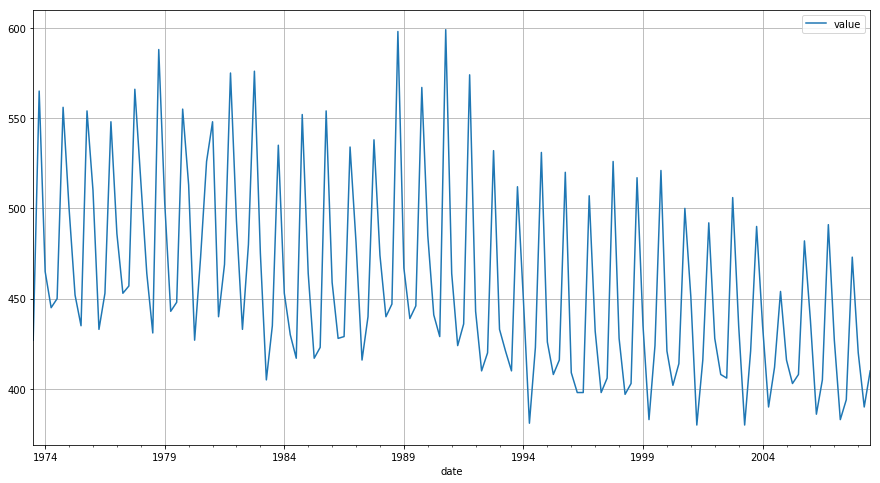

In [10]:
data.plot()
plt.grid()

<span class="text_common"><b>Основные выводы:</b> заметна выраженная годовая сезонность. Кроме того, виден линейный нисходящий тренд. Модель декомпозиции аддитивная, так как дисперсия временного ряда не меняется со временем - весь ряд как бы лежит в пределе полосы одинаковой ширины.</span>

In [11]:
# Модель декомпозиции ряда аддитивная (см. выше). Класс DecompositionType определен в src.utils
dec_model = DecompositionType('additive')

<span class="text_common">Для разложения на компоненты воспользуемся функцией <span class="code">seasonal_decompose</span> - она справляется хорошо.</span>

In [12]:
decomposition = seasonal_decompose(data, extrapolate_trend='freq', model=dec_model.type)
trend = decomposition.trend.dropna()
seasonal = decomposition.seasonal.dropna()
resid = decomposition.resid.dropna()

# На всякий случай проверим, что длины компонент одинаковы
assert len(trend) == len(seasonal) == len(resid)

<span class="text_common">Разделяем на обучающие и тестовые части каждые компоненты ряда. </span>

In [13]:
# На тест возьмем 10% элементов с конца
test_part = 0.1

In [14]:
test_size = int(len(resid) * test_part)
train_size = len(resid) - test_size

In [15]:
trend_train, trend_test = trend.head(train_size), trend.tail(test_size)
seasonal_train, seasonal_test = seasonal.head(train_size), seasonal.tail(test_size)
resid_train, resid_test = resid.head(train_size), resid.tail(test_size)

In [16]:
# Запакуем в трейн и тест соответствующие компоненты ряда 
train = pd.DataFrame(
    [dec_model.evaluate(t, s, r) for (t, s, r) in zip(trend_train.values, seasonal_train.values, resid_train.values)])
train.index = trend_train.index
train.columns = ['value']
test = pd.DataFrame(
    [dec_model.evaluate(t, s, r) for (t, s, r) in zip(trend_test.values, seasonal_test.values, resid_test.values)])
test.index = trend_test.index
test.columns = ['value']

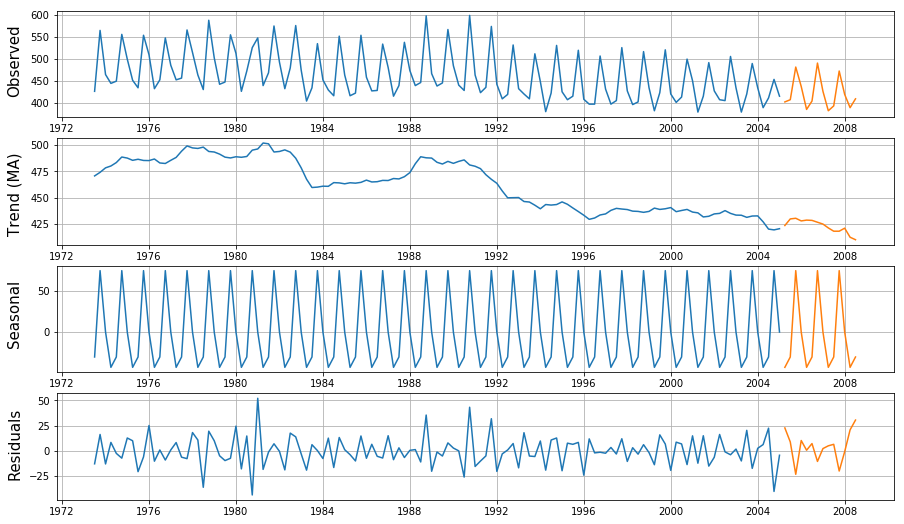

In [17]:
# Построим графики временного ряда и его компонент 
_, ax = plt.subplots(4, 1, figsize=(15, 9))

ax[0].plot(train), ax[0].plot(test), ax[0].grid()
ax[0].set_title('Observed', rotation='vertical', x=-0.05, y=0.7, size=15)
ax[1].plot(trend_train), ax[1].plot(trend_test), ax[1].grid()
ax[1].set_title('Trend (MA)', rotation='vertical', x=-0.05, y=0.7, size=15)
ax[2].plot(seasonal_train), ax[2].plot(seasonal_test), ax[2].grid()
ax[2].set_title('Seasonal', rotation='vertical', x=-0.05, y=0.7, size=15)
ax[3].plot(resid_train), ax[3].plot(resid_test), ax[3].grid()
ax[3].set_title('Residuals', rotation='vertical', x=-0.05, y=0.7, size=15)

plt.show()

<span class="text_common"><b>Основные выводы:</b> в <span class="code">seasonal_decompose</span> применяется скользящее среднее для моделирования тренда и стабильный сезонный фильтр.</span>

# Статистический тест на стационарность стохатической компоненты

<span class="text_common">Надо убедиться, что стохастическая компонента - <span class="code">resid_train</span> - является стационарной. Используем для этого два статистических теста - тест Дики-Фуллера и KPSS тест.</span>

In [18]:
dickey_fuller_test([val[0] for val in resid_train.values])
kpss_test([val[0] for val in resid_train.values])

Тест Дики-Фуллера: ряд стационарный
Тест KPSS: ряд стационарный


# Экстраполяция тренда и сезонности

<span class="common_text">Для прогнозирования тренда используется его последнее значение на тестовой выборке (при экстраполяции на тест), так как используется непараметрическая модель - скользящее среднее. Уравнение для оценки тренда: </span>${\large \mu_{T+k} = z_{T} }$

<span class="common_text">Так как используется стабильный сезонный фильтр, то сезонная компонента экстраполируется также несложно: </span>${\large s_{T+k} = s_{T+k-\Delta}}$

In [19]:
trend_forecast = extrapolate_trend(trend_train, len(trend_test), model_type='MA')

In [20]:
seasonal_forecast = extrapolate_seasonal(seasonal_train, len(seasonal_test))

In [21]:
# Тестовая выборка длиная, так что для наглядности отображать будет 50 её последних значений
train_part_to_plot = 50

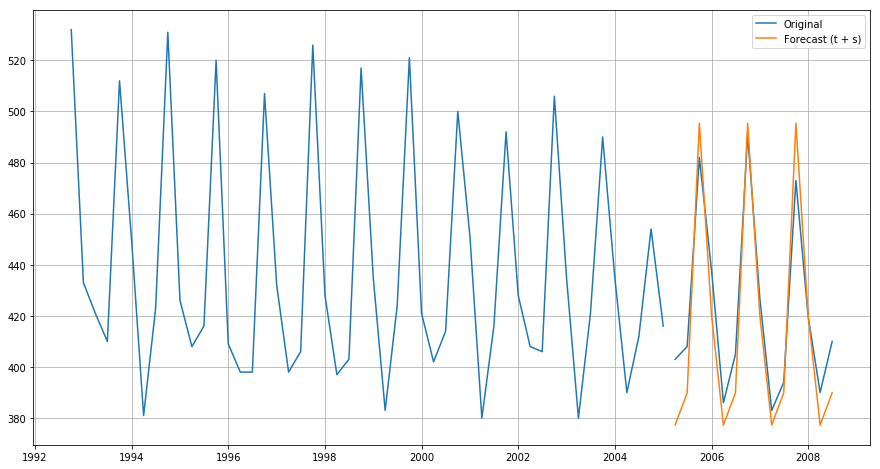

In [22]:
plt.plot(train.index[-train_part_to_plot:], train[-train_part_to_plot:], c='C0')
plt.plot(test.index, test, label='Original')
plt.plot(
    test.index, 
    [dec_model.evaluate(t, s) for (t, s) in zip(trend_forecast, seasonal_forecast)], 
    label='Forecast (t + s)')
plt.legend()
plt.grid()

# Построение ARMA модели для стохастической компоненты

<span class="text_common">Параметры ARMA модели определим по графикам ACF и PACF.</span>

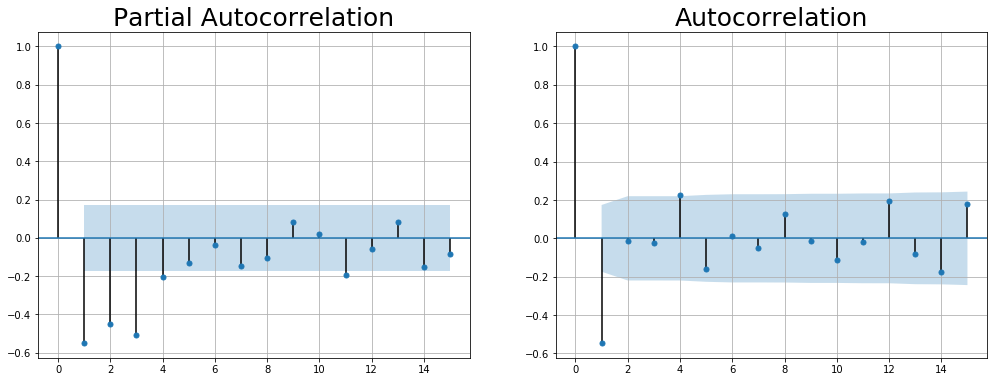

In [23]:
_, ax = plt.subplots(1, 2, figsize=(17,6))
plot_pacf(resid_train, lags=15, ax=ax[0]), ax[0].grid()
plot_acf(resid_train, lags=15, ax=ax[1]), ax[1].grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> <b>p = 4, q = 1</b>. Стоит отметить, что сравнение модели с меньшими по порядку с помощью LR теста показывает, что метрика правдоподобия будет статистически значимо отличаться, поэтому в качестве модели для стохастической компоненты оставим ARMA(4, 1).</span>

In [24]:
ARMAOptimal = ARMA(resid_train, (4, 1))
results = ARMAOptimal.fit()

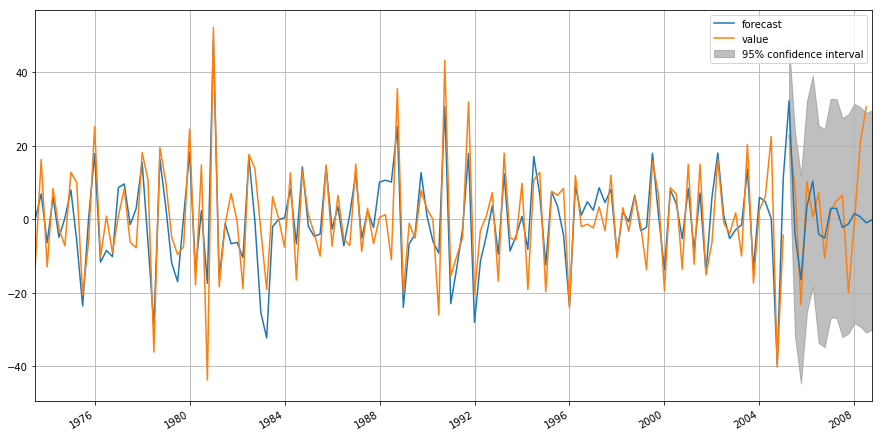

In [25]:
ax = plt.subplot2grid((1, 1), (0, 0))
ax.plot(resid_test, c='C1')
results.plot_predict(0, test_size + train_size, ax=ax)
plt.grid()

<span class="text_common">На данном графике оранжевым цветом представлено истинное значение, а синим - выданное моделью, так как <span class="code">plot_predict</span> не предусматривает какой-либо кастомизации - нельзя построить в общем стиле ноутбука.</span>

In [26]:
resid_forecast, _, conf = results.forecast(test_size)

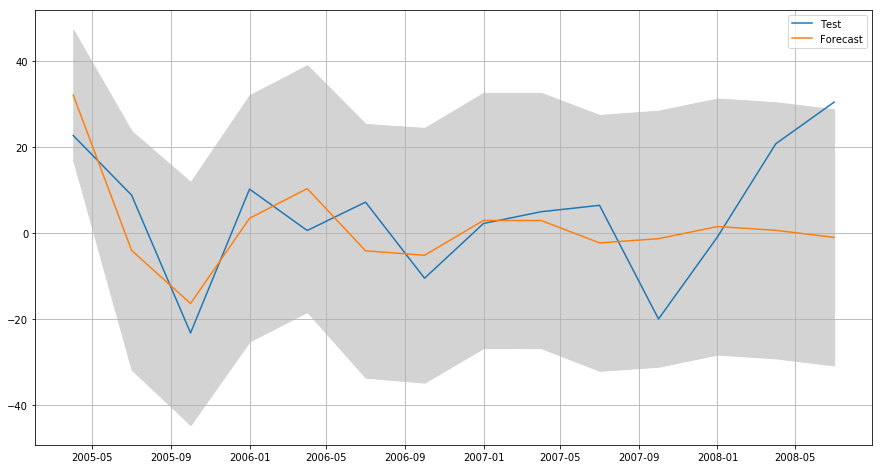

In [27]:
plt.plot(resid_test.index, resid_test, label='Test')
plt.plot(resid_test.index, resid_forecast, label='Forecast')
plt.fill_between(resid_test.index, conf[:, 0], conf[:, 1], color='lightgray')
plt.legend()
plt.grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> истинное значение временного ряда лежит в 95% доверительном интервале для прогноза модели (за исключением самого последнего, которое ненамного вышло за этот интервал).</span>

In [28]:
forecast = pd.DataFrame(
    [dec_model.evaluate(t, s, r) for (s, t, r) in zip(seasonal_forecast, trend_forecast, resid_forecast)], 
    columns=['value'])
forecast.index = trend_test.index

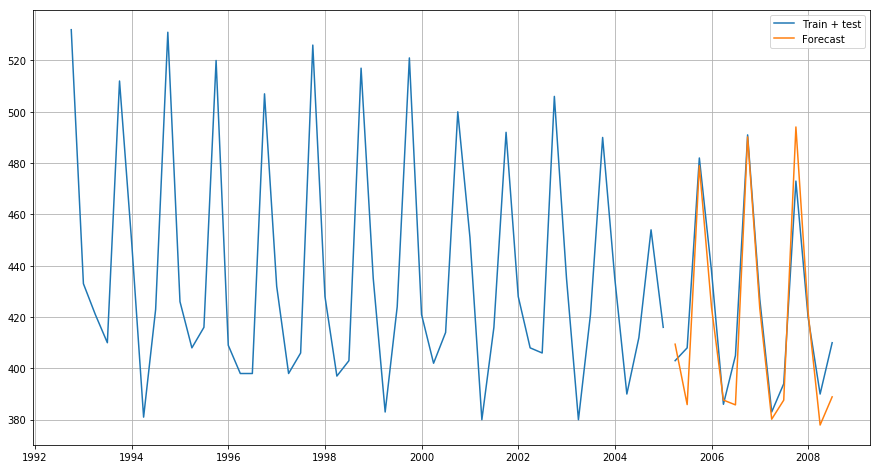

In [29]:
plt.plot(train[-train_part_to_plot:], c='C0')
plt.plot(test, label='Train + test')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.grid()
plt.show()

<span class="text_common"><b>Основные выводы:</b> исходняй ряд на тестовой выборке достаточно хорошо прогнозируется построенной моделью.</span>

# Персистентная модель

In [30]:
from src.metrics import (mean_absolute_percentage_error, 
                         mean_squared_error
                        )

In [31]:
# При сдвиге первый элемент у нас заполняется значением np.nan, 
# туда поместим последнее значение из обучающей выборки
resid_persistent = resid_test.shift().fillna(resid_train.values[-1][0])

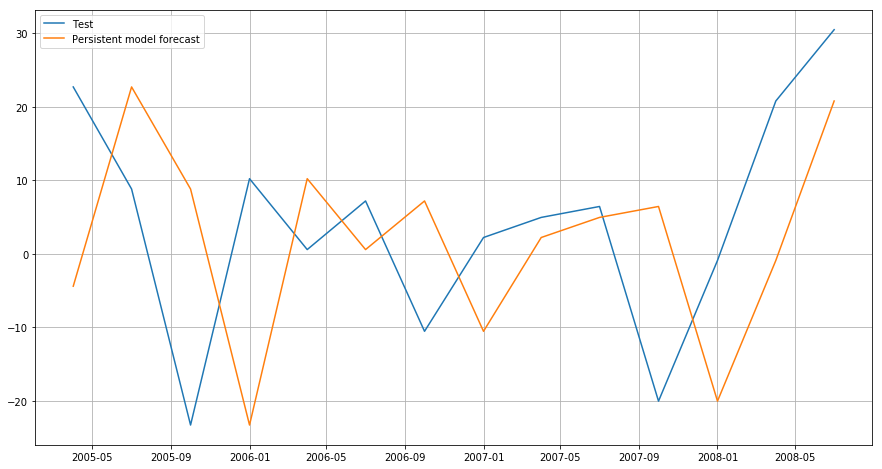

In [32]:
plt.plot(resid_test, label='Test')
plt.plot(resid_persistent, label='Persistent model forecast')
plt.legend()
plt.grid()

In [33]:
print('Persistent model of residuals\nMAPE: {}\nMSE:  {}'.format(
    mean_absolute_percentage_error(resid_test, resid_persistent), 
    mean_squared_error(resid_test, resid_persistent)))

Persistent model of residuals
MAPE: 4.06882846506822
MSE:  381.24676411955534


<span class="text_common"><b>Основные выводы:</b> ошибка на тестовой части ряда для персистентной модели составляет около 4 процентов..</span>

In [34]:
forecast_persistent = test.shift().fillna(train.values[-1][0])

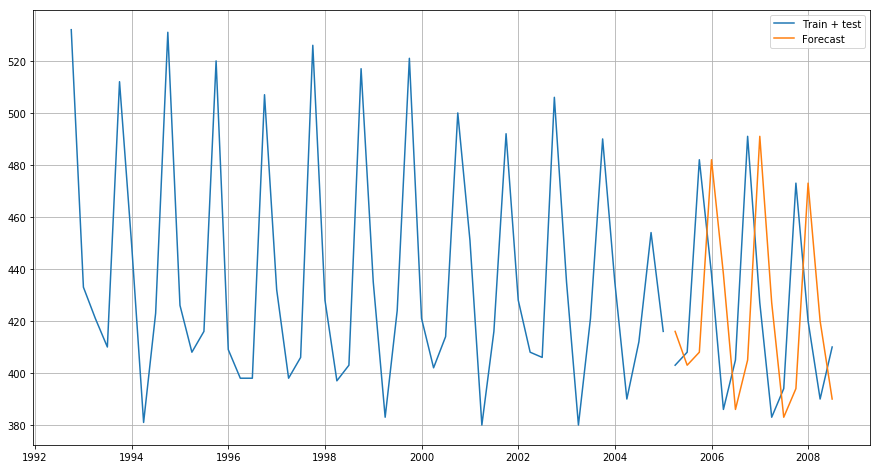

In [35]:
plt.plot(train[-train_part_to_plot:], c='C0')
plt.plot(test, label='Train + test')
plt.plot(forecast_persistent, label='Forecast')
plt.legend()
plt.grid()
plt.show()

In [36]:
print('Persistent model of time series\nMAPE: {}\nMSE:  {}'.format(
    mean_absolute_percentage_error(test, forecast_persistent), 
    mean_squared_error(test, forecast_persistent)))

Persistent model of time series
MAPE: 0.09763394105124742
MSE:  2469.285714285714


<span class="text_common"><b>Основные выводы:</b> на тестовой выборке с помощью персистентной модели достигается прогнозирование с точностью до 0.09 процента.</span>

# Оценка качества модели и сравнение с персистентной моделью

In [37]:
print('Residuals\nMAPE: {}\nMSE:  {}'.format(
    mean_absolute_percentage_error(resid_test, resid_forecast), 
    mean_squared_error(resid_test, resid_forecast)))

Residuals
MAPE: 2.0828544174270127
MSE:  174.11514873607933


In [38]:
print('Time series\nMAPE: {}\nMSE:  {}'.format(
    mean_absolute_percentage_error(test, forecast), 
    mean_squared_error(test, forecast)))

Time series
MAPE: 0.02326523375078531
MSE:  158.15319840857242


<span class="text_common"><b>Основные выводы:</b> отметим, что метрики качества для полного прогноза (тренд, сезонность и остатки вместе) лучше - средняя абсолютная процентная ошибка составляет 0.02 процента, в то время как прогноз стохастической компоненты ряда имеет ошибку 2.08 процента. Обе метрики для модели ARMA(4, 1) показывают лучшие оценки, чем для персистентной модели ряда.</span>